In [1]:
import sys
sys.path.append('../../numpy/1D')

from utils import *
from env import *
from model import *
from matplotlib import gridspec

In [2]:
# set directory to folder with model trained with different place field parameter combinations
data_dir = "/Users/mganeshkumar/Library/CloudStorage/OneDrive-HarvardUniversity/Code/online_pf_learning/online/1D/"

In [3]:
def plot_pcacts(pcacts, title, ax=None):
    if ax is None:
        f,ax = plt.subplots()
    xs = np.linspace(-1,1,1001)
    for i in range(pcacts.shape[1]):
        ax.plot(xs, pcacts[:,i])
    ax.plot(xs, np.sum(pcacts,axis=1), color='k',linewidth=3)
    ax.hlines(xmin=-envsize,xmax=envsize, y=0, colors='k')
    ax.axvline(-0.75, color='g',linestyle='--',label='Start', linewidth=2)
    ax.axvline(0.5, color='r',linestyle='--',label='Goal', linewidth=2)
    #plt.ylim([-0.25, 1.25])
    ax.set_title(title)
    ax.set_ylabel('Tuning curves $\phi(x)$')
    ax.set_xlabel('Location (x)')

def relu(x):
    return np.maximum(x,0)

def get_ca1(ca3, U):
    ca1_sr = []
    for i in range(ca3.shape[0]):
        ca1_sr.append(relu(U) @ ca3[i])
    return np.array(ca1_sr)


def plot_sr_pc(Us, ca3, trial,title='', ax=None, goalcoord=[0.5], startcoord=[-0.75], goalsize=0.05, envsize=1,):
    if ax is None:
        f,ax = plt.subplots()

    # Get a colormap that transitions from purple to yellow
    cmap = cm.viridis
    num_curves = ca3.shape[1]
    xs = np.linspace(-1,1,1001)
    for i in range(num_curves):
        color = cmap(i / num_curves)
        ca1 = get_ca1(ca3, Us[trial])
        ax.plot(xs, ca1[:, i], color=color,zorder=1)

    dx = np.mean(ca1,axis=1)
    ax2 = ax.twinx()
    ax2.plot(xs, dx,color='k', zorder=2)
    ax2.set_ylabel('$d_\psi(x)$')

    ax.set_xlabel('x')
    ax.set_ylabel('$\psi(x)$')
    ax.set_title(title)

    # ax2 = ax.twinx()
    ax.fill_between(xs, reward_func(xs, goalcoord, goalsize), color='red', alpha=0.25, label='Target',zorder=2)
    ax.axvline(startcoord[0],ymin=0, ymax=1, color='g',linestyle='--',label='Start', linewidth=2,zorder=2)
    ax.hlines(xmin=-envsize,xmax=envsize, y=0, colors='k',zorder=2)
    # ax2.set_ylabel('$R(x)$')

def plot_sr_field_area(Us, ca3, trials,ax=None):
    if ax is None:
        f,ax = plt.subplots()
    
    areas = []
    for trial in trials:
        ca1 = get_ca1(ca3, Us[trial])
        area = np.trapz(ca1,axis=0)
        areas.append(area)
    areas = np.array(areas)

    norm_area = areas/areas[0]

    mean_deltas = np.mean(norm_area,axis=1)
    sem_deltas = np.std(norm_area,axis=1)/np.sqrt(len(logparams[0][0]))
    ax.plot(trials, mean_deltas, color='tab:orange')
    ax.fill_between(trials, mean_deltas - sem_deltas, mean_deltas + sem_deltas, alpha=0.2, color='tab:orange')
    # ax.plot(trials,mean_deltas, color='tab:orange')
    # ax.fill_between(trials, mean_deltas - sem_deltas, mean_deltas + sem_deltas, color='tab:orange', alpha=0.2)
    ax.set_ylabel('Norm SR Field Area')
    return norm_area


def plot_sr_center(Us,ca3, trials,ax=None):
    if ax is None:
        f,ax = plt.subplots()
    ca1_init = get_ca1(ca3, Us[0])
    xs = np.linspace(-1,1,1001)
    deltas = []
    for trial in trials:
        ca1 = get_ca1(ca3, Us[trial])
        d = []
        for n in range(ca3.shape[1]):
            # ca3_center = xs[np.argmax(ca3[:,n])]
            orig_ca1_center = xs[np.argmax(ca1_init[:,n])]
            ca1_center = xs[np.argmax(ca1[:,n])]
            delta = ca1_center - orig_ca1_center# - ca3_center
            d.append(delta)
        deltas.append(np.array(d))
    deltas = np.array(deltas)

    mean_deltas = np.mean(deltas,axis=1)
    sem_deltas =  np.std(deltas,axis=1)/np.sqrt(ca3.shape[1])
    # ax.errorbar(trials, mean_deltas, yerr=sem_deltas, fmt='s', color='tab:orange')
    ax.plot(trials, mean_deltas, color='tab:orange')
    ax.fill_between(trials, mean_deltas - sem_deltas, mean_deltas + sem_deltas, color='tab:orange', alpha=0.2)
    ax.set_ylabel('$\Delta$ SR Field Centers')
    return deltas

def plot_sr_density(Us,ca3, trials,ax=None, goalcoord=0.5, goalsize=0.05, startcoord=[-0.75], envsize=1):
    if ax is None:
        f,ax=plt.subplots()
    xs = np.linspace(-1,1,1001)
    for trial in trials:
        ca1 = get_ca1(ca3, Us[trial])
        dx = np.sum(ca1,axis=1)/ca1.shape[1]
        ax.plot(xs, dx, label=f'T={trial}', zorder=2)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$d_\psi(x)$')
    ax.legend(frameon=False, fontsize=8, loc=9)
    ax.set_title('Density learnd using SR')

    ax2 = ax.twinx()
    ax2.fill_between(xs, reward_func(xs, goalcoord, goalsize), color='red', alpha=0.25, label='Target', zorder=1)
    ax.axvline(startcoord[0],ymin=0, ymax=1, color='g',linestyle='--',label='Start', linewidth=2, zorder=1)
    ax.hlines(xmin=-envsize,xmax=envsize, y=0, colors='k', zorder=1)
    ax2.set_ylabel('$R(x)$')
    return dx

def get_frequency(allcoords, trial, gap=50):
    xs = np.linspace(-1,1,1001)
    fx = []
    for g in range(gap):
        fx.append(allcoords[trial-g-1])
    fx = np.array(flatten(fx))
    kde = gaussian_kde(fx.reshape(-1))
    fx_smooth = kde(xs)
    px = fx_smooth/np.sum(fx_smooth)
    return px

def get_sr_1D_frequency_density_corr(allcoords, Us, param, trial, gap=25):
    xs = np.linspace(-1,1,1001)
    ca3 = predict_batch_placecell(param, xs)

    dx = []
    fx = []

    for g in range(gap):
        fx.append(allcoords[trial-g-1])

        ca1_sr = []
        for i in range(ca3.shape[0]):
            ca1_sr.append(relu(Us[trial-g-1]) @ ca3[i])
        ca1_sr = np.array(ca1_sr)

        density = np.mean(ca1_sr,axis=1)
        dx.append(density)
    
    fx = np.array(flatten(fx))
    kde = gaussian_kde(fx.reshape(-1))
    fx_smooth = kde(xs)

    dx = np.array(dx)
    dx = np.mean(dx,axis=0)
    R,pval = stats.pearsonr(fx_smooth, dx)

    return xs, fx_smooth, dx, R, pval


def plot_sr_fxdx_trials(allcoords, Us, logparams, trials,gap, ax=None):
    if ax is None:
        f,ax = plt.subplots()
    
    Rs = []
    fxs = []
    dxs = []
    pvals = []
    for trial in trials:
        visits, frequency, density, R, pval = get_sr_1D_frequency_density_corr(allcoords, Us,logparams[0], trial, gap=gap)
        Rs.append(R)
        pvals.append(pval)
        fxs.append(frequency)
        dxs.append(density)
    pvals =np.array(pvals)
    Rs = np.array(Rs)
    ax.plot(trials, Rs, color='tab:orange')
    # significant_mask = pvals < 0.05
    # ax.plot(np.array(trials)[significant_mask], Rs[significant_mask], 's', color='tab:orange')

    return np.array(fxs), np.array(dxs), Rs

def plot_rm_sr_corr(rm_dx, sr_dx,trials, ax=None):
    if ax is None:
        f,ax = plt.subplots()
    
    Rs = []
    pvals = []
    assert len(rm_dx) == len(sr_dx)

    for t,trial in enumerate(trials):
        R,pval = stats.pearsonr(sr_dx[t], rm_dx[t])
        Rs.append(R)
        pvals.append(pval)

    pvals =np.array(pvals)
    Rs = np.array(Rs)
    ax.plot(trials, Rs, color='tab:green')
    # significant_mask = pvals < 0.05
    # ax.plot(np.array(trials)[significant_mask], Rs[significant_mask], '^', color='tab:green')

def compare_rm_sr_pv(logparams, ca3, Us, trials):
    # if ax is None:
    #     f,ax = plt.subplots()

    xs = np.linspace(-1,1,1001)
    pv_corr = np.zeros([len(trials)])
    rep_corr = np.zeros([len(trials)])
    trackpc = np.zeros([2, len(trials), len(xs), len(logparams[0][0])])
    trackrep = np.zeros([2, len(trials), len(xs), len(xs)])

    for i, trial in enumerate(trials):
        # RM PV
        rmpcs = predict_batch_placecell(logparams[trial], xs)
        rm_rep = rmpcs@rmpcs.T

        srpcs = get_ca1(ca3, Us[trial])
        sr_rep = srpcs@srpcs.T

        pv_corr[i],pval = stats.pearsonr(rmpcs.flatten(), srpcs.flatten())
        rep_corr[i],pval = stats.pearsonr(rm_rep.flatten(), sr_rep.flatten())

        trackpc[0,i] = rmpcs
        trackpc[1,i] = srpcs
        trackrep[0,i] = rm_rep
        trackrep[1,i] = sr_rep

    return pv_corr,rep_corr, trackpc, trackrep, trials

def get_field_area(logparams, trials):
    areas = []
    xs = np.linspace(-1,1,1001)
    for trial in trials:
        ca1 = predict_batch_placecell(logparams[trial], xs)
        area = np.trapz(ca1,axis=0)
        area = np.mean(ca1>1e-3,axis=0)
        areas.append(area)
    areas = np.array(areas)
    deltas = areas-areas[0]

    mean_deltas = np.mean(deltas,axis=1)
    sem_deltas =  np.std(deltas,axis=1)/np.sqrt(ca1.shape[1])

    return mean_deltas, sem_deltas

def get_field_center(logparams, trials,ax=None):
    xs = np.linspace(-1,1,1001)
    ca3_init = predict_batch_placecell(logparams[0], xs)

    deltas = []
    for trial in trials:
        ca3 = predict_batch_placecell(logparams[trial], xs)
        d = []
        for n in range(ca3.shape[1]):
            # ca3_center = xs[np.argmax(ca3[:,n])]
            orig_ca3_center = xs[np.argmax(ca3_init[:,n])]
            ca1_center = xs[np.argmax(ca3[:,n])]
            delta = ca1_center - orig_ca3_center# - ca3_center
            d.append(delta)
        deltas.append(np.array(d))
    deltas = np.array(deltas)
    
    mean_deltas = np.mean(deltas,axis=1)
    sem_deltas =  np.std(deltas,axis=1)/np.sqrt(ca3.shape[1])

    return mean_deltas, sem_deltas

def get_sr_field_area(Us, ca3, trials):
   
    areas = []
    for trial in trials:
        ca1 = get_ca1(ca3, Us[trial])
        area = np.trapz(ca1,axis=0)
        area = np.mean(ca1>1e-3,axis=0)
        areas.append(area)
    areas = np.array(areas)
    deltas = areas-areas[0]

    mean_deltas = np.mean(deltas,axis=1)
    sem_deltas =  np.std(deltas,axis=1)/np.sqrt(ca3.shape[1])

    return mean_deltas, sem_deltas


def get_sr_center(Us,ca3, trials):
    ca1_init = get_ca1(ca3, Us[0])
    xs = np.linspace(-1,1,1001)
    deltas = []
    for trial in trials:
        ca1 = get_ca1(ca3, Us[trial])
        d = []
        for n in range(ca3.shape[1]):
            # ca3_center = xs[np.argmax(ca3[:,n])]
            orig_ca1_center = xs[np.argmax(ca1_init[:,n])]
            ca1_center = xs[np.argmax(ca1[:,n])]
            delta = ca1_center - orig_ca1_center# - ca3_center
            d.append(delta)
        deltas.append(np.array(d))
    deltas = np.array(deltas)
    mean_deltas = np.mean(deltas,axis=1)
    sem_deltas =  np.std(deltas,axis=1)/np.sqrt(ca3.shape[1])

    return mean_deltas, sem_deltas

def normalize_means_and_scale_std(means, stds):
    # Compute the minimum and maximum of the mean values
    mu_min = np.min(means)
    mu_max = np.max(means)
    
    # Normalize the mean values to the range [0, 1]
    normalized_means = (means - mu_min) / (mu_max - mu_min)
    
    # Compute the scaling factor
    scaling_factor = 1 / (mu_max - mu_min)
    
    # Scale the standard deviations
    scaled_stds = stds * scaling_factor
    
    return normalized_means, scaled_stds

def get_mean_ci(x):
    return np.mean(x,axis=0), 1.96*np.std(x,axis=0) / np.sqrt(x.shape[0])


In [4]:
num = 51
gap = 50
train_episodes = 50000
trials = np.logspace(np.log10(gap),np.log10(train_episodes), num,dtype=int)+1

sr_field_area_mean = []
sr_field_center_mean = []
rm_field_area_mean = []
rm_field_center_mean = []

sr_field_area_std = []
sr_field_center_std = []
rm_field_area_std = []
rm_field_center_std = []

for npc in [16, 64]:
    for seed in range(3):
        print(npc, seed)

        if seed == 0:
            sr_exptname = f"1D_td_online_0.0ns_0p_{npc}n_0.01plr_0.01clr_0.0llr_0.0alr_0.0slr_uni_0.5a_0.1s_{seed}s_50000e_5rmax_0.05rsz"
            exptname = f"1D_td_online_0.0ns_0p_{npc}n_0.01plr_0.01clr_0.0001llr_0.0001alr_0.0001slr_uni_0.5a_0.1s_{seed}s_50000e_5rmax_0.05rsz"
        else:
            sr_exptname = f"full_1D_td_online_0.0ns_0p_{npc}n_0.01plr_0.01clr_0.0llr_0.0alr_0.0slr_uni_0.5a_0.1s_2a_{seed}s_50000e_5rmax_0.05rsz"
            exptname = f"full_1D_td_online_0.0ns_0p_{npc}n_0.01plr_0.01clr_0.0001llr_0.0001alr_0.0001slr_uni_0.5a_0.1s_2a_{seed}s_50000e_5rmax_0.05rsz"



        [sr_logparams, sr_latencys,sr_cum_rewards, sr_allcoords] = saveload(data_dir+f"/data/dx_data/full_{sr_exptname}",1,"load")
        [Us, ca3] = saveload(data_dir+f'/data/sr_data/sr_0.0025_{sr_exptname}', 1, 'load')
        [logparams, latencys,cum_rewards, allcoords] = saveload(data_dir+f"/data/dx_data/full_{exptname}",1,"load")

        srma, srsa = get_sr_field_area(Us, ca3, trials)
        srmc, srsc = get_sr_center(Us,ca3, trials)

        rmma, rmsa = get_field_area(logparams, trials)
        rmmc, rmsc = get_field_center(logparams, trials)


        sr_field_area_mean.append(srma)
        sr_field_center_mean.append(srmc)
        rm_field_area_mean.append(rmma)
        rm_field_center_mean.append(rmmc)

        sr_field_area_std.append(srsa)
        sr_field_center_std.append(srsc)
        rm_field_area_std.append(rmsa)
        rm_field_center_std.append(rmsc)

sr_field_area_mean = np.array(sr_field_area_mean)
sr_field_center_mean = np.array(sr_field_center_mean)
rm_field_area_mean = np.array(rm_field_area_mean)
rm_field_center_mean = np.array(rm_field_center_mean)

sr_field_area_std = np.array(sr_field_area_std)
sr_field_center_std = np.array(sr_field_center_std)
rm_field_area_std = np.array(rm_field_area_std)
rm_field_center_std = np.array(rm_field_center_std)
print(sr_field_area_mean.shape, rm_field_center_mean.shape)
    

16 0
16 1
16 2
64 0
64 1
64 2
(6, 51) (6, 51)


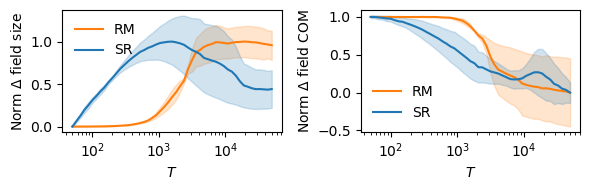

In [5]:
f,axs = plt.subplots(1,2,figsize=(6,2))

# field area
rm_area_mean = np.mean(rm_field_area_mean,axis=0)
rm_area_std = 1.96*np.std(rm_field_area_mean,axis=0) / np.sqrt(rm_field_area_mean.shape[0])
rm_area_mean, rm_area_std = normalize_means_and_scale_std(rm_area_mean, rm_area_std)

sr_area_mean = np.mean(sr_field_area_mean,axis=0)
sr_area_std = 1.96*np.std(sr_field_area_mean,axis=0) / np.sqrt(sr_field_area_mean.shape[0])
sr_area_mean, sr_area_std = normalize_means_and_scale_std(sr_area_mean, sr_area_std)

axs[0].plot(trials, rm_area_mean,label='RM', color='tab:orange')
axs[0].fill_between(trials, rm_area_mean - rm_area_std,  rm_area_mean + rm_area_std, alpha=0.2, color='tab:orange')

axs[0].plot(trials, sr_area_mean,label='SR', color='tab:blue')
axs[0].fill_between(trials, sr_area_mean - sr_area_std,  sr_area_mean + sr_area_std, alpha=0.2, color='tab:blue')
axs[0].legend(frameon=False, loc=2)
axs[0].set_ylabel('Norm $\Delta$ field size')
axs[0].set_xscale('log')
# axs[0].set_title('Field widths elongate')
axs[0].set_xlabel('$T$')

# field center
rm_center_mean = np.mean(rm_field_center_mean,axis=0)
rm_center_std = 1.96*np.std(rm_field_center_mean,axis=0) / np.sqrt(rm_field_center_mean.shape[0])
rm_center_mean, rm_center_std = normalize_means_and_scale_std(rm_center_mean, rm_center_std)

sr_center_mean = np.mean(sr_field_center_mean,axis=0)
sr_center_std = 1.96*np.std(sr_field_center_mean,axis=0)  / np.sqrt(sr_field_center_mean.shape[0])
sr_center_mean, sr_center_std = normalize_means_and_scale_std(sr_center_mean, sr_center_std)

axs[1].plot(trials, rm_center_mean,label='RM', color='tab:orange')
axs[1].fill_between(trials, rm_center_mean - rm_center_std,  rm_center_mean + rm_center_std, alpha=0.2, color='tab:orange')

axs[1].plot(trials, sr_center_mean,label='SR', color='tab:blue')
axs[1].fill_between(trials, sr_center_mean - sr_center_std,  sr_center_mean + sr_center_std, alpha=0.2, color='tab:blue')
axs[1].legend(frameon=False, loc=3)
axs[1].set_ylabel('Norm $\Delta$ field COM')
axs[1].set_xscale('log')
# axs[1].set_title('Field centers shift backwards')
axs[1].set_xlabel('$T$')

f.tight_layout()
# f.savefig("./svgs/sr_rm_width_center_2m_3s_norm.svg")

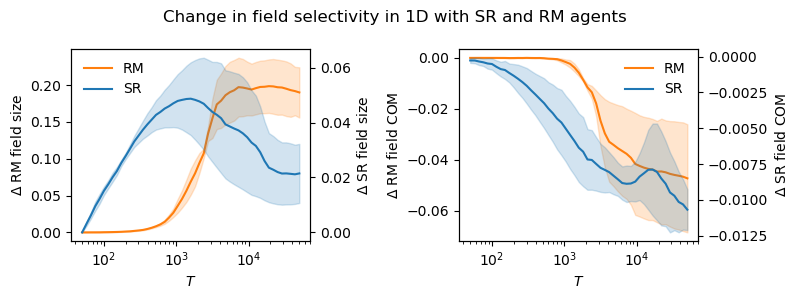

In [6]:
f,axs = plt.subplots(1,2,figsize=(8,3))

# field area
rm_area_mean = np.mean(rm_field_area_mean,axis=0)
rm_area_std = np.std(rm_field_area_mean,axis=0) * 1.96 / np.sqrt(rm_field_area_mean.shape[0])

sr_area_mean = np.mean(sr_field_area_mean,axis=0)
sr_area_std = np.std(sr_field_area_mean,axis=0) * 1.96 / np.sqrt(sr_field_area_mean.shape[0])

axs[0].plot(trials, rm_area_mean, color='tab:orange')
axs[0].fill_between(trials, rm_area_mean - rm_area_std,  rm_area_mean + rm_area_std, alpha=0.2, color='tab:orange')
axs[0].set_ylabel('$\Delta$ RM field size')
axs[0].set_xscale('log')
axs[0].set_xlabel('$T$')

axs[0].plot([],[],label='RM', color='tab:orange')
axs[0].plot([],[],label='SR', color='tab:blue')
axs[0].legend(frameon=False, loc=0)
ax1 = axs[0].twinx()
ax1.plot(trials, sr_area_mean, color='tab:blue')
ax1.fill_between(trials, sr_area_mean - sr_area_std,  sr_area_mean + sr_area_std, alpha=0.2, color='tab:blue')
ax1.set_ylabel('$\Delta$ SR field size')

# field center
rm_center_mean = np.mean(rm_field_center_mean,axis=0)
rm_center_std = np.std(rm_field_center_mean,axis=0) * 1.96 / np.sqrt(rm_field_center_mean.shape[0])

sr_center_mean = np.mean(sr_field_center_mean,axis=0)
sr_center_std = np.std(sr_field_center_mean,axis=0) * 1.96 / np.sqrt(sr_field_center_mean.shape[0])

axs[1].plot(trials, rm_center_mean, color='tab:orange')
axs[1].fill_between(trials, rm_center_mean - rm_center_std,  rm_center_mean + rm_center_std, alpha=0.2, color='tab:orange')
axs[1].set_xscale('log')
axs[1].set_xlabel('$T$')
axs[1].set_ylabel('$\Delta$ RM field COM')
axs[1].plot([],[],label='RM', color='tab:orange')
axs[1].plot([],[],label='SR', color='tab:blue')
axs[1].legend(frameon=False, loc=0)

ax2 = axs[1].twinx()
ax2.plot(trials, sr_center_mean, color='tab:blue')
ax2.fill_between(trials, sr_center_mean - sr_center_std,  sr_center_mean + sr_center_std, alpha=0.2, color='tab:blue')
ax2.set_ylabel('$\Delta$ SR field COM')
f.suptitle('Change in field selectivity in 1D with SR and RM agents')
f.tight_layout()
# f.savefig("./svgs/sr_rm_width_center_2m_3s.svg")

In [7]:
def get_fxdx_trials(allcoords, logparams, trials,gap,ax=None):

    Rs = []
    pvals = []
    fxs = []
    dxs = []
    for trial in trials:
        visits, frequency, density, R, pval = get_1D_freq_density_corr(allcoords, logparams, trial, gap=gap)
        Rs.append(R)
        pvals.append(pval)
        fxs.append(frequency)
        dxs.append(density)
    pvals =np.array(pvals)
    Rs = np.array(Rs)

    return np.array(fxs), np.array(dxs), Rs

def get_sr_fxdx_trials(allcoords, Us, logparams, trials,gap):

    Rs = []
    fxs = []
    dxs = []
    pvals = []
    for trial in trials:
        visits, frequency, density, R, pval = get_sr_1D_frequency_density_corr(allcoords, Us,logparams[0], trial, gap=gap)
        Rs.append(R)
        pvals.append(pval)
        fxs.append(frequency)
        dxs.append(density)
    pvals =np.array(pvals)
    Rs = np.array(Rs)
    return np.array(fxs), np.array(dxs), Rs

def get_rm_sr_corr(rm_fxs,sr_fxs,rm_dx, sr_dx,trials, ax=None):
    
    fx_Rs = []
    dx_Rs = []
    pvals = []
    assert len(rm_dx) == len(sr_dx)

    for t,trial in enumerate(trials):
        dx_R,pval = stats.pearsonr(sr_dx[t], rm_dx[t])
        dx_Rs.append(dx_R)

        R,pval = stats.pearsonr(sr_fxs[t], rm_fxs[t])
        fx_Rs.append(R)

    dx_Rs = np.array(dx_Rs)
    fx_Rs = np.array(fx_Rs)
    return fx_Rs, dx_Rs

sr_fx_dx_mean= []
rm_fx_dx_mean = []
sr_rm_dx_mean = []
sr_rm_fx_mean = []

sr_rm_field_mean = []
sr_rm_sm_mean = []

num = 51
trials = np.logspace(np.log10(gap),np.log10(train_episodes), num,dtype=int)+1
for npc in [16, 64]:
    for seed in range(3):
        print(npc, seed)

        if seed == 0:
            sr_exptname = f"1D_td_online_0.0ns_0p_{npc}n_0.01plr_0.01clr_0.0llr_0.0alr_0.0slr_uni_0.5a_0.1s_{seed}s_50000e_5rmax_0.05rsz"
            exptname = f"1D_td_online_0.0ns_0p_{npc}n_0.01plr_0.01clr_0.0001llr_0.0001alr_0.0001slr_uni_0.5a_0.1s_{seed}s_50000e_5rmax_0.05rsz"
        else:
            sr_exptname = f"full_1D_td_online_0.0ns_0p_{npc}n_0.01plr_0.01clr_0.0llr_0.0alr_0.0slr_uni_0.5a_0.1s_2a_{seed}s_50000e_5rmax_0.05rsz"
            exptname = f"full_1D_td_online_0.0ns_0p_{npc}n_0.01plr_0.01clr_0.0001llr_0.0001alr_0.0001slr_uni_0.5a_0.1s_2a_{seed}s_50000e_5rmax_0.05rsz"

        [logparams, latencys,cum_rewards, allcoords] = saveload(data_dir+f"/data/dx_data/full_{exptname}",1,"load")
        [sr_logparams, sr_latencys,sr_cum_rewards, sr_allcoords] = saveload(data_dir+f"/data/dx_data/full_{sr_exptname}",1,"load")
        [Us, ca3] = saveload(data_dir+f'/data/sr_data/sr_0.0025_{sr_exptname}', 1, 'load')

        rm_fxs, rm_dxs, rm_fx_dx_Rs = get_fxdx_trials(allcoords, logparams,trials, gap=gap)
        sr_fxs, sr_dxs, sr_fx_dx_Rs = get_sr_fxdx_trials(sr_allcoords, Us,sr_logparams, trials, gap=gap)
        fx_Rs, dx_Rs = get_rm_sr_corr(rm_fxs,sr_fxs, rm_dxs, sr_dxs,trials, ax=axs[0])

        sr_fx_dx_mean.append(sr_fx_dx_Rs)
        rm_fx_dx_mean.append(rm_fx_dx_Rs)
        sr_rm_dx_mean.append(dx_Rs)
        sr_rm_fx_mean.append(fx_Rs)


        pv_corr,rep_corr,_, _,trials  = compare_rm_sr_pv(logparams, ca3, Us, trials)

        sr_rm_field_mean.append(pv_corr)
        sr_rm_sm_mean.append(rep_corr)

sr_fx_dx_mean = np.array(sr_fx_dx_mean)
rm_fx_dx_mean = np.array(rm_fx_dx_mean)
sr_rm_dx_mean = np.array(sr_rm_dx_mean)
sr_rm_fx_mean = np.array(sr_rm_fx_mean)
sr_rm_field_mean = np.array(sr_rm_field_mean)
sr_rm_sm_mean = np.array(sr_rm_sm_mean)

print(sr_fx_dx_mean.shape,sr_rm_sm_mean.shape )


16 0
16 1
16 2
64 0
64 1
64 2
(6, 51) (6, 51)


(6, 51)
(6, 51)
(6, 51)
(6, 51)


/var/folders/9w/2t7dk80j0vncsnz93dbrg1080000gp/T/ipykernel_94140/1553545363.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', 256)


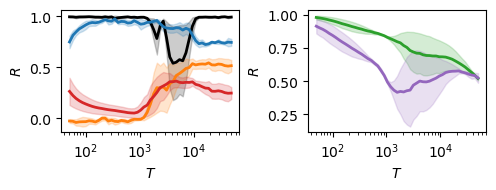

<Figure size 640x480 with 0 Axes>

In [8]:
f2,axs = plt.subplots(1,2,figsize=(5,2))


for data, label, color in zip([sr_rm_fx_mean, sr_fx_dx_mean,rm_fx_dx_mean,sr_rm_dx_mean],
                              ['$p_{SR}:p_{RM}$', '$p_{SR}:\sum \phi_{\psi}$', '$p_{RM}:\sum \phi_{\phi}$','$\sum \phi_\psi:\sum \phi_\phi$' ],
                              ['k', 'tab:blue', 'tab:orange', 'tab:red']):
    print(data.shape)
    m,s = get_mean_ci(data)

    axs[0].plot(trials, m,label=label, color=color, linewidth=2)
    axs[0].fill_between(trials, m - s,  m + s, alpha=0.2, color=color)


# axs[0].set_title('f(x):d(x)')
# axs[0].legend(frameon=False, loc=0, fontsize=8)
axs[0].set_xlabel('$T$')
axs[0].set_ylabel('$R$')
# axs[0].set_title('Field density comparison')
axs[0].set_xscale('log')


# Define the colormap
viridis = cm.get_cmap('viridis', 256)

# Get the darkest (index 0) and lightest (index 255) colors
dark_color = viridis(0)
light_color = viridis(255)

for data, label, color in zip([sr_rm_field_mean,sr_rm_sm_mean],
                              ['$\psi_i : \phi_i$', '$\psi\\psi^\\top : \phi \phi^\\top$'],
                              ['tab:green', 'tab:purple']):
    m,s = get_mean_ci(data)

    axs[1].plot(trials, m,label=label, color=color, linewidth=2)
    axs[1].fill_between(trials, m - s,  m + s, alpha=0.2, color=color)

# axs[1].set_title('Individual field comparison')
axs[1].set_xlabel('$T$')
axs[1].set_ylabel('$R$')
# axs[1].legend(frameon=False, loc=0, fontsize=10)
axs[1].set_xscale('log')

f2.tight_layout()
plt.subplots_adjust(right=1)  # Make space for the combined legend

# f2.savefig('./svgs/sr_rm_dx_px_field_R.svg')
# f2.savefig('./svgs/sr_rm_dx_px_field_R.png')

handles, labels = axs[0].get_legend_handles_labels()
handles2, labels2 = axs[1].get_legend_handles_labels()
handles.extend(handles2)
labels.extend(labels2)

fig_legend = plt.figure()
fig_legend.legend(handles, labels, loc='center', frameon=True, fontsize=10)
# fig_legend.savefig('./svgs/sr_rm_dx_px_legend.svg')
# fig_legend.savefig('./svgs/sr_rm_dx_px_legend.png')

## Individual agent

In [9]:
def plot_data_in_axes(ax_top, ax_bottom, xs, pcacts, dx, fx, goalcoord, startcoord, goalsize, envsize, title, sign, name):
    # Plot data in bottom axis
    cmap = cm.viridis
    num_curves = pcacts.shape[1]
    for i in range(num_curves):
        color = cmap(i / num_curves)
        ax_bottom.plot(xs, pcacts[:, i], color=color, zorder=1)
    
    max_val = np.maximum(pcacts.max(), 1)
    ax_bottom.set_ylabel(f'${sign}(x)$')  # Set y label with minimal padding
    # ax_bottom.set_xlabel('$x$')
    ax_bottom.set_xticks([])
    ax_bottom.fill_between(xs, reward_func(xs, goalcoord, goalsize), color='red', alpha=0.25, label='Target', zorder=2)
    ax_bottom.axvline(startcoord[0], ymin=0, ymax=max_val, color='g', linestyle='--', label='Start', linewidth=2, zorder=2)
    ax_bottom.hlines(xmin=-envsize, xmax=envsize, y=0, colors='k', zorder=2)
    ax_bottom.spines['top'].set_visible(False)  # Remove the top axis line for ax_bottom

    # Move y label to top
    # ax_bottom.yaxis.set_label_position('right')  # Change the label position to the right
    # ax_bottom.yaxis.set_label_coords(1.05, 0.5)  # Adjust coordinates

    # Use scientific notation for y-ticks


    # Plot data in bottom axis of ax_top
    ax2 = ax_top.twinx()
    ax2.plot(xs, dx, color='r', zorder=2)
    ax2.set_ylabel(f'$\sum {sign}(x)$', color='r')


    ax_top.set_xticks([])  # Remove x axis ticks on top axis
    ax_top.set_title(title)  # Set the title for the top plot
    ax_top.spines['bottom'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    
    ax_bottom.axhline(y=max_val, color='gray', linestyle='--', linewidth=0.5)

    ax_top.plot(xs, fx, color='k', zorder=1)
    ax_top.set_ylabel(name)  # Set y label with minimal padding

    # Move y label to top
    # ax_top.yaxis.set_label_position('right')  # Change the label position to the right
    # ax_top.yaxis.set_label_coords(1.05, 0.5)  # Adjust coordinates

    # Use scientific notation for y-ticks
    ax2.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
    ax_bottom.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
    ax_top.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
    ax_top.set_yticks([])  # Remove x axis ticks on top axis
    ax2.set_yticks([])  # Remove x axis ticks on top axis
    ax_bottom.set_yticks([])  # Remove x axis ticks on top axis

def main_plot(allcoords,logparams, trials1, allcoords_sr,ca3, Us,trials2, goalcoord=[0.5], startcoord=[-0.75], goalsize=0.05, envsize=1):
    num_plots = len(trials1)
    num_rows = 2  # We'll have 3 rows
    num_cols = num_plots  # We'll have 2 columns (total 3*2 = 6 main subplots)

    for j in range(2):
        fig = plt.figure(figsize=(2*num_plots, 2))
        gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.5, hspace=0)  # adjust as necessary

        xs = np.linspace(-1, 1, 1001)

        for i in range(num_plots):
            row = i // num_cols
            col = i % num_cols
            
            # Create main subplots grid
            ax_main = plt.subplot(gs[row, col])
            
            # Create top and bottom inset axes
            gs_main = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[row, col], height_ratios=[0.5, 1], hspace=0.0)
            ax_top = plt.subplot(gs_main[0])
            ax_bottom = plt.subplot(gs_main[1])

            # Get data for the current trial
            if j == 0:
                fx = get_frequency(allcoords, trials1[i], gap=50)
                pcacts = predict_batch_placecell(logparams[trials1[i]], xs)
                sign = '\phi'
                trials = trials1
                name = '$p_{RM}(x)$'
            else:
                fx = get_frequency(allcoords_sr, trials2[i], gap=50)
                pcacts = get_ca1(ca3, Us[trials2[i]])
                sign = '\psi'
                trials = trials2
                name = '$p_{SR}(x)$'

            dx = np.mean(pcacts, axis=1)
            
            # Plot data
            plot_data_in_axes(ax_top, ax_bottom, xs, pcacts, dx,fx, goalcoord, startcoord, goalsize, envsize, title=f"T={trials[col]}", sign=sign, name=name)

        # Shared title for the entire figure
        # fig.savefig(f"./svgs/sr_rm_pcs_density_{sign}.svg")


In [10]:
# load sr agent

exptname = f"full_1D_td_online_0.0ns_0p_16n_0.01plr_0.01clr_0.0llr_0.0alr_0.0slr_uni_0.5a_0.1s_2a_1s_50000e_5rmax_0.05rsz"
[sr_logparams, sr_latencys,sr_cum_rewards, sr_allcoords] = saveload(data_dir+f"/data/dx_data/full_{exptname}",1,"load")
[Us, ca3] = saveload(data_dir+f'./data/sr_data/sr_0.0025_{exptname}', 1, 'load')

exptname = f"full_1D_td_online_0.0ns_0p_16n_0.01plr_0.01clr_0.0001llr_0.0001alr_0.0001slr_uni_0.5a_0.1s_2a_1s_50000e_5rmax_0.05rsz"
[logparams, latencys,cum_rewards, allcoords] = saveload(data_dir+f"/data/dx_data/full_{exptname}",1,"load")


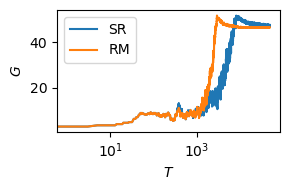

In [11]:
window = 100
f,ax = plt.subplots(1,1,figsize=(3,2))

ax.plot(moving_average(sr_cum_rewards,window), label='SR')
ax.plot(moving_average(cum_rewards,window), label='RM')
ax.set_ylabel('$G$')
ax.set_xlabel('$T$')
ax.set_xscale('log')
ax.legend()
f.tight_layout()

# f.savefig('./svgs/sr_rm_agent_G.svg')

/var/folders/9w/2t7dk80j0vncsnz93dbrg1080000gp/T/ipykernel_94140/2141334053.py:73: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_top = plt.subplot(gs_main[0])


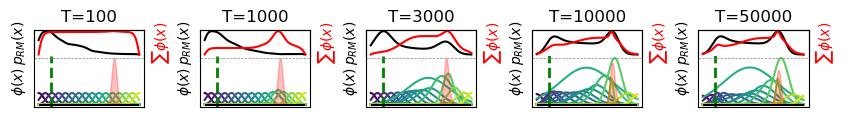

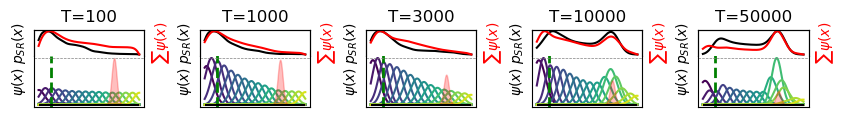

In [12]:


# Example usage
trials2 = [100, 1000, 3000, 10000, 50000]  # Assume we have 12 trials
trials1 = [100,1000, 3000,10000, 50000]
main_plot(allcoords, logparams, trials1,sr_allcoords, ca3, Us,trials2)

1000


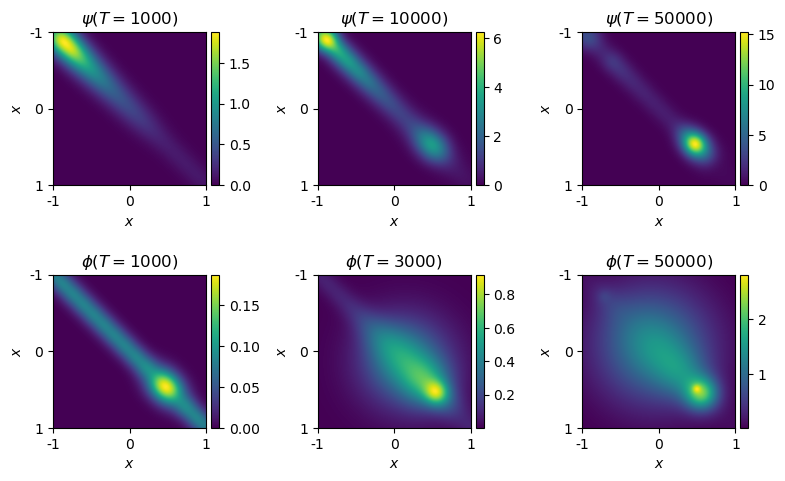

In [13]:
pv_corr,rep_corr,trackpc, trackrep,trials  = compare_rm_sr_pv(logparams, ca3, Us, np.linspace(0,50000,51,dtype=int))

from mpl_toolkits.axes_grid1 import make_axes_locatable
f,ax = plt.subplots(2,3,figsize=(8,5))

for i,idx in enumerate([1, 10,50]):
    im = ax[0,i].imshow(trackrep[1,idx])
    divider = make_axes_locatable(ax[0, i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im,cax=cax)
    ax[0,i].set_title(f'$\psi(T={trials[idx]})$')
    ax[0,i].set_xticks([0,1001//2,1001],[-1,0,1])
    ax[0,i].set_yticks([0,1001//2,1001],[-1,0,1])
    ax[0,i].set_xlabel('$x$')
    ax[0,i].set_ylabel('$x$')


for i,idx in enumerate([1, 3, 50]):
    im = ax[1,i].imshow(trackrep[0,idx])
    divider = make_axes_locatable(ax[1, i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im,cax=cax)
    ax[1,i].set_title(f'$\phi(T={trials[idx]})$')
    ax[1,i].set_xticks([0,1001//2,1001],[-1,0,1])
    ax[1,i].set_yticks([0,1001//2,1001],[-1,0,1])
    ax[1,i].set_xlabel('$x$')
    ax[1,i].set_ylabel('$x$')
f.tight_layout()
# f.savefig("./svgs/sr_rm_repsim.svg")

print(trials[np.argmin(np.diag(rep_corr))])